# Impact climatique du secteur électrique français

Tout d'abord, chargeons l'ensemble des données RTE disponibles pour les années 2012 à 2019 (inclus). Ces données ont été téléchargées ici:
* [Production et consommation](https://opendata.reseaux-energies.fr/explore/dataset/eco2mix-national-cons-def/information/)
* [Températures moyennes et de référence](https://opendata.reseaux-energies.fr/explore/dataset/pic-journalier-consommation-brute/information/)
* [Capacités installées](https://opendata.reseaux-energies.fr/explore/dataset/parc-prod-par-filiere/information/)

Ces dernières sont représentés par un tableau à 2 dimensions dont les colonnes sont les différentes variables dont nous disposons et chaque ligne un pas demi-horaire.

Les variables de consommation, de production et de capacités sont en MW et les températures en °C. Le champs 'date' contient la date du jour et le champ 'datetime', le début du slot horaire UTC.

In [1]:
source('./utils.r')
data = get_country_data('france') # get data from .csv
print(names(data))

 [1] "date"                   "datetime"               "conso"                 
 [4] "oil"                    "coal"                   "gas"                   
 [7] "nuclear"                "wind"                   "solar"                 
[10] "hydro"                  "hydro_pumped_storage"   "bioenergies"           
[13] "physical_flow"          "oil_turbine"            "oil_cogen"             
[16] "oil_others"             "gas_turbine"            "gas_cogen"             
[19] "gas_ccg"                "gas_others"             "hydro_run_of_river"    
[22] "hydro_lake"             "hydro_pumped_discharge" "waste"                 
[25] "biomass"                "biogas"                 "year"                  
[28] "solar_capacities"       "wind_capacities"        "day_peak"              
[31] "mean_temperature"       "reference_temperature" 


Calculons pour chaque pas horaire les émissions de GES associées à la production. Nous utilisons ici les facteurs d'émission en kg CO2eq/kWh de la [Base Carbone de l'ADEME](https://www.bilans-ges.ademe.fr/).

In [2]:
ADEME_GHG_FACTORS = c(0.006, 0.006, 0.013, 0.055, 0.418, 0.494, 0.73, 1.06)
names(ADEME_GHG_FACTORS) = c('hydro', 'nuclear', 'wind', 'solar', 'gas', 'bioenergies', 'oil', 'coal')
ADEME_GHG_FACTORS

hydro     nuclear        wind       solar         gas bioenergies 
      0.006       0.006       0.013       0.055       0.418       0.494 
        oil        coal 
      0.730       1.060

In [3]:
data = add_co2_kg(data, ADEME_GHG_FACTORS)
add_co2_kg

function (data, ghg_factors) 
{
    data = data %>% mutate(co2_kg = 0) %>% add_prod()
    for (prod_type in names(ghg_factors)) {
        data[["co2_kg"]] = data[["co2_kg"]] + data[[prod_type]] * 
            ghg_factors[prod_type] * 500
    }
    data = data %>% mutate(co2_kg_kwh = co2_kg/prod/500)
    data
}
<bytecode: 0x7f869c36d448>

Nous avons maintenant les émission en kg CO2eq pour chaque pas demi-horaire. Affichons maintenant les émissions annuels depuis 2012 du secteur électrique français.

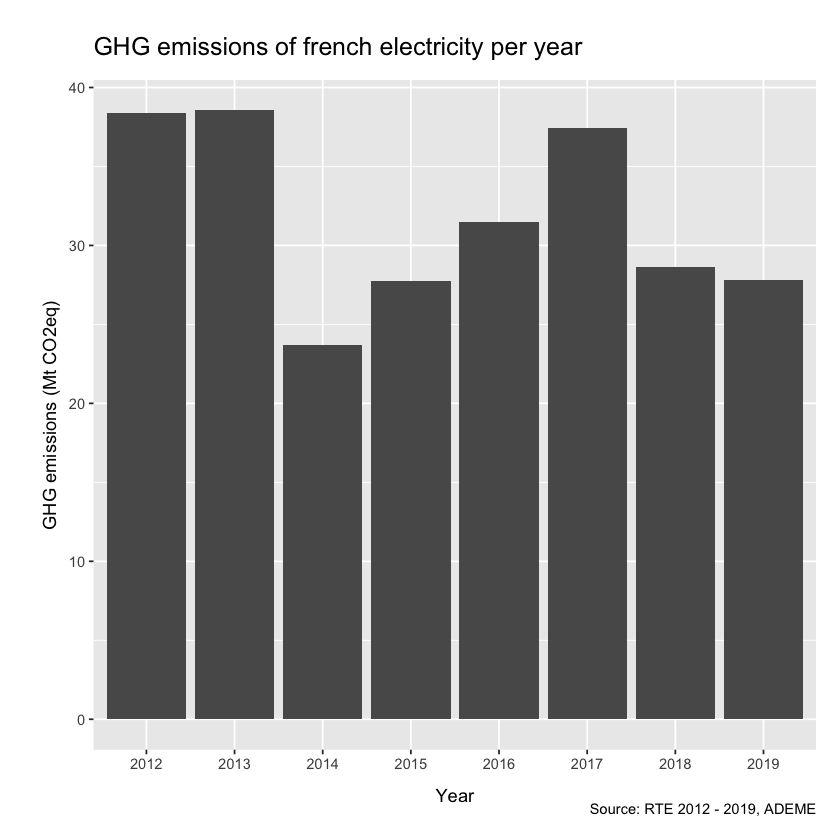

In [4]:
yearly_emissions = data %>%
    group_by(year) %>%
    summarise(
        co2_mt = sum(co2_kg) / 10^9 # conversion from kg to Mt
    )

# use of paste to change year to string, make variable discrete
ggplot(yearly_emissions, aes(x = paste(year), y = co2_mt)) + 
    geom_col() +
    labs(
        title = 'GHG emissions of french electricity per year',
        x = 'Year',
        y = 'GHG emissions (Mt CO2eq)',
        caption = 'Source: RTE 2012 - 2019, ADEME'
    )

Mais nous avons aussi l'intensité carbone de la productio en kg CO2eq/kWh pour chaque pas demi-horaire. Nous allons donc pouvoir nous intéresser à l'évolution de sa distribution.

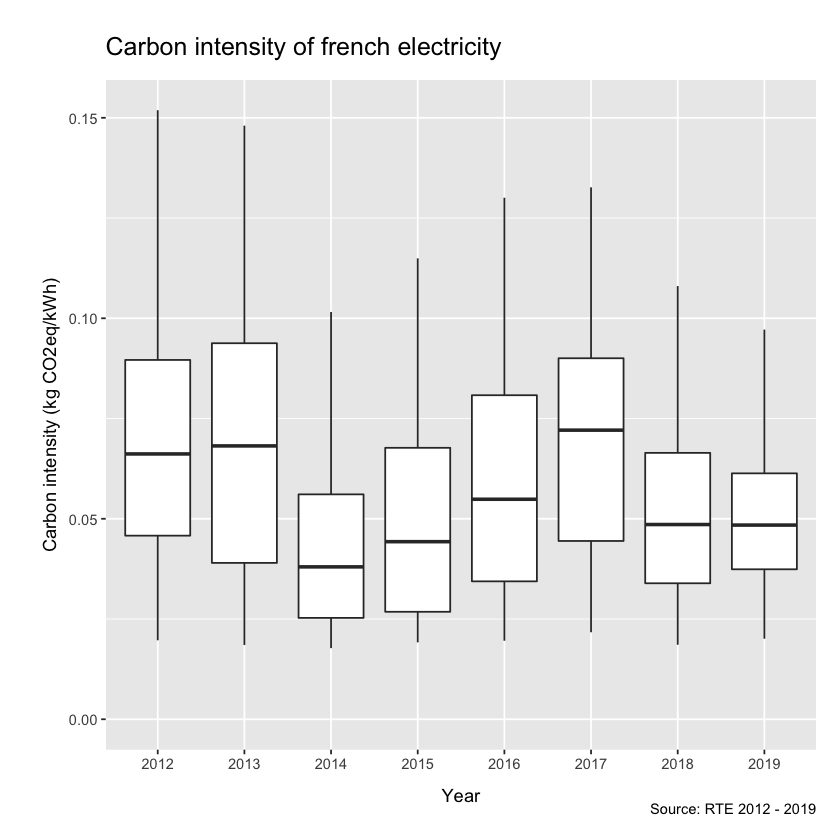

In [5]:
ggplot(data, aes(x = paste(year), y = co2_kg_kwh)) +
    geom_boxplot(outlier.shape = NA) + 
    scale_y_continuous(limits = c(0, NA)) +
    labs(
        title = 'Carbon intensity of french electricity',
        x = 'Year',
        y = 'Carbon intensity (kg CO2eq/kWh)',
        caption = 'Source: RTE 2012 - 2019'
    )

Et voilà la petite démo terminée, n'hésitez pas à consulter les coulisses dans le fichier `utils.r` via Fichier > Ouvrir ou à modifier comme il vous semble cette présentation.

Quelques ressources sur les structures de données et la librairie graphique:
* [Structure de données](https://github.com/rstudio/cheatsheets/blob/master/data-import.pdf)
* [Transformations](https://github.com/rstudio/cheatsheets/blob/master/data-transformation.pdf)
* [Visualisation](https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf)
